# INTRO

The following is code to analyze the cause and affects of ocean acidification over time. This code will clean the data, perform an EDA, and analyze.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler


# CLEAN DATA & EDA

###pH Levels
https://www.epa.gov/climate-indicators/climate-change-indicators-ocean-acidity

In [ ]:
hawaii=pd.read_csv("https://www.epa.gov/system/files/other-files/2024-06/ocean-acidity_fig-1.csv", encoding='ISO-8859-1',skiprows=6)
hawaii=hawaii.iloc[:, :-13]
hawaii.dropna(inplace=True)
hawaii

,Hawaii Year,Hawaii pH,Hawaii pCO2
0,1988.833333,8.1097,330.9
1,1988.920765,8.1092,330.6
2,1989.021918,8.1168,324.3
3,1989.156164,8.1316,310.9
4,1989.235616,8.1218,317.7
...,...,...,...
325,2022.238356,8.0522,390.5
326,2022.402740,8.0376,404.3
327,2022.523288,8.0491,396.2
328,2022.580822,8.0368,409.0


In [ ]:

# Rename and set datetime column
decimal_years = hawaii['Hawaii Year']

# Readjust year
def decimal_to_datetime(decimal_year):
    year = int(decimal_year)
    fraction = decimal_year - year

    month = int(fraction * 12) + 1
    return pd.Timestamp(year=year, month=month, day=1)

converted_dates = [decimal_to_datetime(dy) for dy in decimal_years]

hawaii['time'] = hawaii['Hawaii Year'].apply(decimal_to_datetime)

hawaii

,Hawaii Year,Hawaii pH,Hawaii pCO2,time
0,1988.833333,8.1097,330.9,1988-10-01
1,1988.920765,8.1092,330.6,1988-12-01
2,1989.021918,8.1168,324.3,1989-01-01
3,1989.156164,8.1316,310.9,1989-02-01
4,1989.235616,8.1218,317.7,1989-03-01
...,...,...,...,...
325,2022.238356,8.0522,390.5,2022-03-01
326,2022.402740,8.0376,404.3,2022-05-01
327,2022.523288,8.0491,396.2,2022-07-01
328,2022.580822,8.0368,409.0,2022-07-01


In [ ]:
# Average by year
hawaii['year'] = hawaii['time'].dt.year
CO2_avg = hawaii.groupby('year')['Hawaii pCO2'].mean()
pH_avg = hawaii.groupby('year')['Hawaii pH'].mean()
hawaii_avg = pd.merge(CO2_avg, pH_avg, on='year', how='inner')

hawaii_avg.reset_index(level=0, inplace=True)
hawaii_avg['time'] = pd.to_datetime(hawaii_avg['year'], format='%Y')

hawaii_avg.head()

,year,Hawaii pCO2,Hawaii pH,time
0,1988,330.750000,8.109450,1988-01-01
1,1989,331.560000,8.107480,1989-01-01
2,1990,323.022222,8.118611,1990-01-01
3,1991,329.360000,8.111090,1991-01-01
4,1992,332.772727,8.107482,1992-01-01


<ipython-input-7-26af0e0927d7>:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


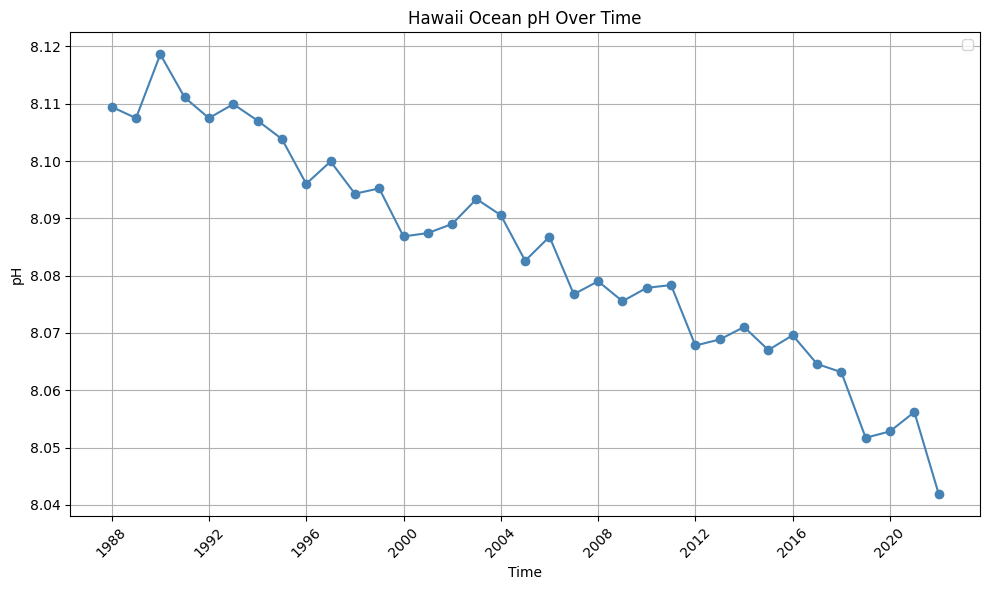

In [ ]:
# Plot
ph=hawaii_avg[['time','Hawaii pH']].copy()

plt.figure(figsize=(10, 6))
plt.plot(ph['time'], ph['Hawaii pH'],marker='o', linestyle='-', color='steelblue')
plt.title('Hawaii Ocean pH Over Time')
plt.xlabel('Time')
plt.ylabel('pH')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

###CO2 (same source)

<ipython-input-8-9a39028a77fc>:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


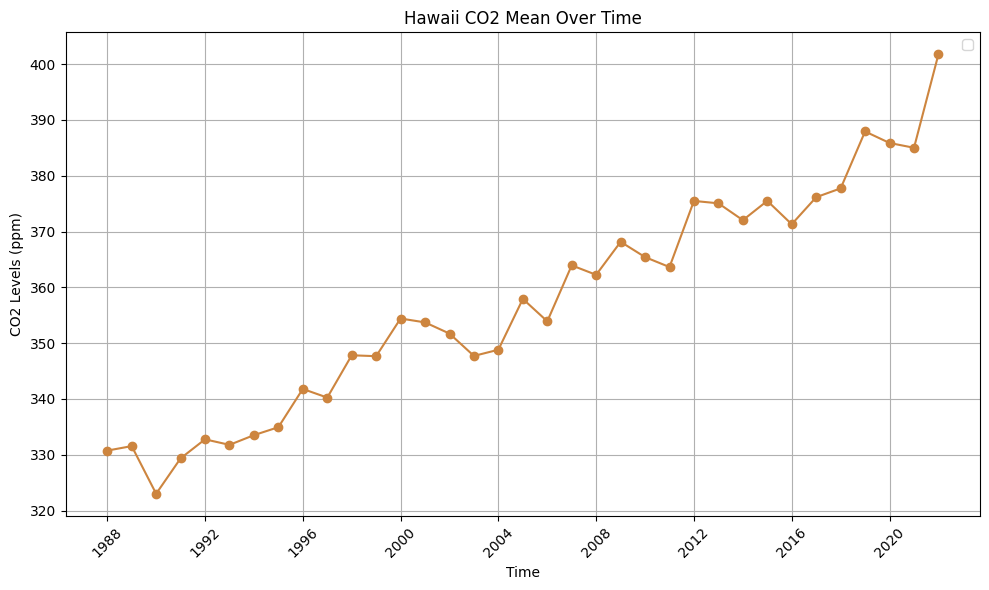

In [ ]:
co2=hawaii_avg[['time','Hawaii pCO2']].copy()

plt.figure(figsize=(10, 6))
plt.plot(co2['time'], co2['Hawaii pCO2'], marker='o', linestyle='-', color='peru')
plt.title('Hawaii CO2 Mean Over Time')
plt.xlabel('Time')
plt.ylabel('CO2 Levels (ppm)')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()


###Sea Surface Temp
https://www.st.nmfs.noaa.gov/nauplius/pickup/d3ba06fece054bc8b43ee95de8f98c43/

In [ ]:
temp=pd.read_csv("https://www.st.nmfs.noaa.gov/nauplius/pickup/d3ba06fece054bc8b43ee95de8f98c43/data/dataRSST_HadISST.csv")
temp.head()

,DATE-YMD,HSST= HadISST Temperature (C),Unnamed: 2
0,1900-01-15,23.71,NaN
1,1900-02-15,23.31,NaN
2,1900-03-15,23.27,NaN
3,1900-04-15,23.52,NaN
4,1900-05-15,24.26,NaN


In [ ]:
# Adjust time date
temp = temp.rename(columns={'DATE-YMD':'time','HSST= HadISST Temperature (C)':'Ocean Surface Temperature (C)'})
temp['time'] = pd.to_datetime(temp.time)
temp=temp.drop(columns='Unnamed: 2')
temp.head()

,time,Ocean Surface Temperature (C)
0,1900-01-15,23.71
1,1900-02-15,23.31
2,1900-03-15,23.27
3,1900-04-15,23.52
4,1900-05-15,24.26


In [ ]:
# Average by year
temp['year'] = temp['time'].dt.year
temp_avg = hawaii.groupby('year')['Hawaii pCO2'].mean()
temp_avg = temp_avg.reset_index()
temp_avg.columns = ['year', 'Ocean Surface Temperature (C)'] # Rename columns for clarity

temp_avg.reset_index(level=0, inplace=True)
temp_avg['time'] = pd.to_datetime(temp_avg['year'], format='%Y')
temp_avg = temp_avg.drop(['year', 'index'], axis=1)

temp_avg.head()

,Ocean Surface Temperature (C),time
0,330.750000,1988-01-01
1,331.560000,1989-01-01
2,323.022222,1990-01-01
3,329.360000,1991-01-01
4,332.772727,1992-01-01


<ipython-input-12-7147d33a127e>:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


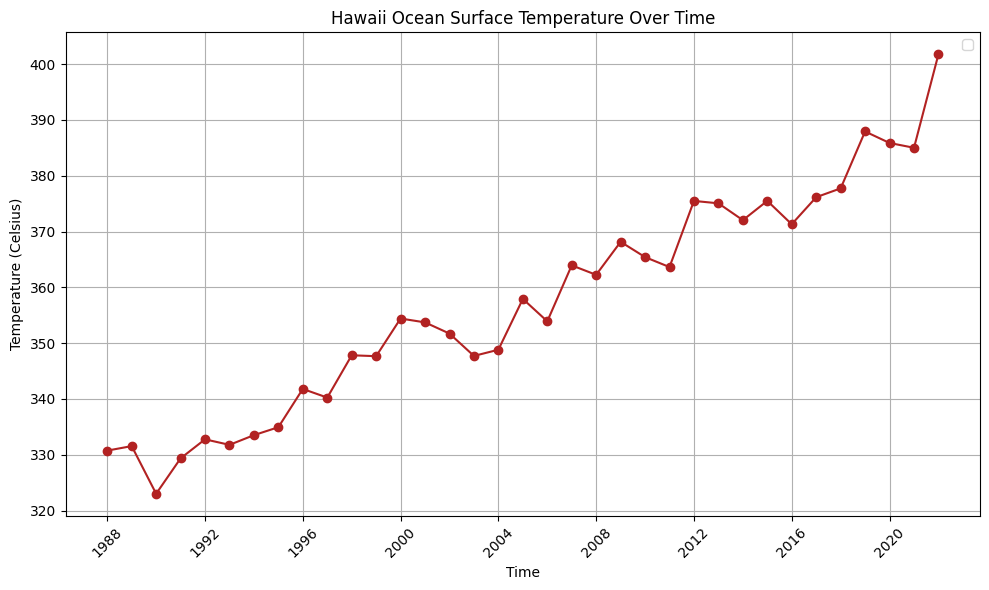

In [ ]:
# Plot
x=temp_avg['time']
y=temp_avg['Ocean Surface Temperature (C)']

plt.figure(figsize=(10, 6))
plt.plot(x, y,marker='o', linestyle='-', color='firebrick')
plt.title('Hawaii Ocean Surface Temperature Over Time')
plt.xlabel('Time')
plt.ylabel('Temperature (Celsius)')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

### Global Temperature
https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/global/time-series

In [ ]:
global_temp=pd.read_csv("https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/global/time-series/globe/tavg/land_ocean/1/2/1850-2025/data.csv", skiprows=4)
global_temp.head()

,Year,Anomaly
0,1850,-0.17
1,1851,-0.03
2,1852,-0.20
3,1853,-0.21
4,1854,-0.15


In [ ]:
# Adjust time
global_temp = global_temp.rename(columns={'Year':'time','Anomaly':'Global Temperature Anomaly (C)'})
global_temp['time'] = pd.to_datetime(global_temp.time, format='%Y')
global_temp.head()

,time,Global Temperature Anomaly (C)
0,1850-01-01,-0.17
1,1851-01-01,-0.03
2,1852-01-01,-0.20
3,1853-01-01,-0.21
4,1854-01-01,-0.15


<ipython-input-15-d9b464207865>:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


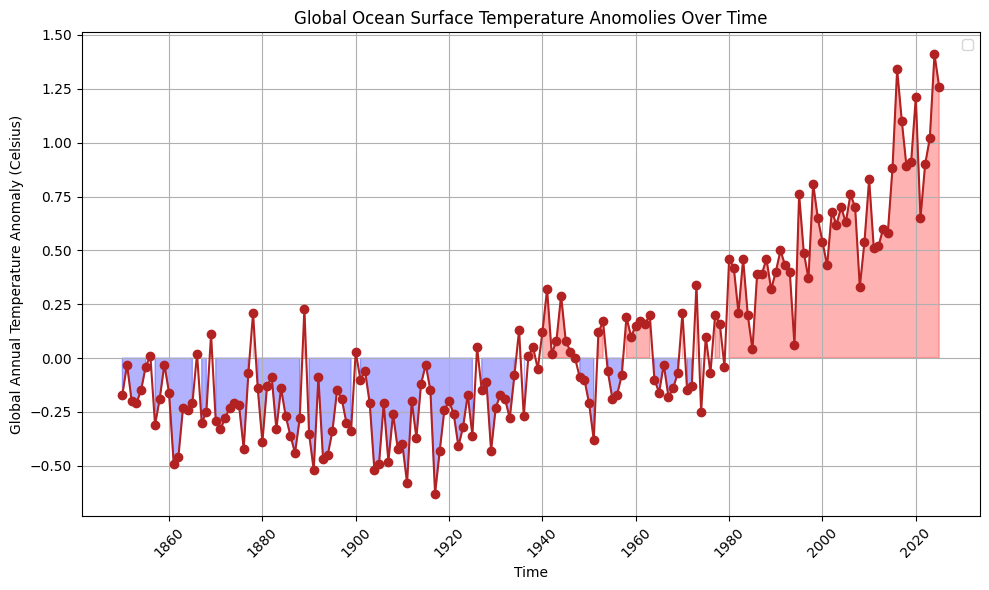

In [ ]:
# Plot
x=global_temp['time']
y=global_temp['Global Temperature Anomaly (C)']

plt.figure(figsize=(10, 6))
plt.errorbar(x, y,marker='o', linestyle='-', color='firebrick')
plt.title('Global Ocean Surface Temperature Anomolies Over Time')
plt.fill_between(x, y, where=(y > 0), color='red', alpha=0.3)
plt.fill_between(x, y, where=(y < 0), color='blue', alpha=0.3)
plt.xlabel('Time')
plt.ylabel('Global Annual Temperature Anomaly (Celsius)')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

### Volcano Eruptions

https://volcano.si.edu/

In [ ]:
volc_dict= {
    "Year": [1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999,
             2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
             2016, 2017, 2018, 2019, 2020, 2021, 2022],
    "Eruptions": [60, 75, 64, 64, 57, 60, 67, 61, 60, 62, 65, 61, 56, 59, 70,
                  75, 70, 74, 65, 81, 83, 86, 81, 86, 75, 77, 76, 81, 80, 79, 90,
                  86, 75, 82, 75, 72, 82, 84]
}
volcano = pd.DataFrame(volc_dict)
volcano.head()

,Year,Eruptions
0,1985,60
1,1986,75
2,1987,64
3,1988,64
4,1989,57


In [ ]:
# Adjust time
volcano['time'] = pd.to_datetime(volcano['Year'], format='%Y')
volcano=volcano.drop(columns='Year')
volcano.head()

,Eruptions,time
0,60,1985-01-01
1,75,1986-01-01
2,64,1987-01-01
3,64,1988-01-01
4,57,1989-01-01


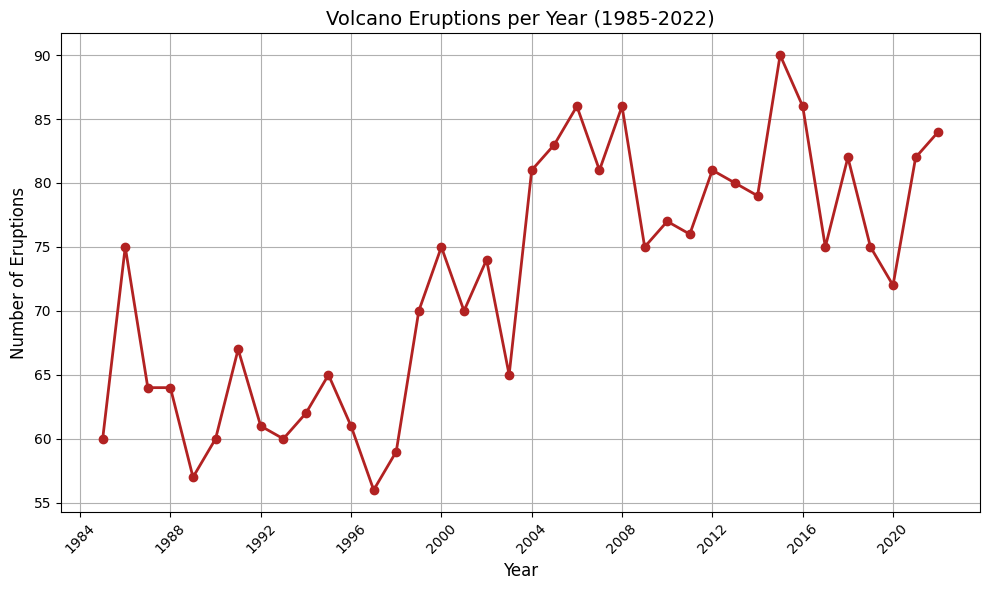

In [ ]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(volcano['time'], volcano['Eruptions'], marker='o', color='firebrick', linestyle='-', linewidth=2, markersize=6)

# Add labels and title
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Eruptions', fontsize=12)
plt.title('Volcano Eruptions per Year (1985-2022)', fontsize=14)

# Display the plot
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###Plankton Population
https://www.st.nmfs.noaa.gov/nauplius/pickup/d3ba06fece054bc8b43ee95de8f98c43/

In [ ]:
plank=pd.read_csv("https://www.st.nmfs.noaa.gov/nauplius/pickup/d3ba06fece054bc8b43ee95de8f98c43/data/dataNPP_CbPM2.csv")
plank.head()

,DATE-YMD,CHLA= CbPM2 NPP (mg-C/m2/day),Unnamed: 2
0,2003-01-15,469.104,NaN
1,2003-02-15,367.183,NaN
2,2003-03-15,307.755,NaN
3,2003-04-15,392.172,NaN
4,2003-05-15,328.367,NaN


In [ ]:
plank = plank.rename(columns={'DATE-YMD':'time', 'CHLA= CbPM2 NPP (mg-C/m2/day)':'Chlorophyll Levels (mg-C/m2/day)'})
plank['time'] = pd.to_datetime(plank.time)
plank=plank.drop(columns='Unnamed: 2')
plank.head()

,time,Chlorophyll Levels (mg-C/m2/day)
0,2003-01-15,469.104
1,2003-02-15,367.183
2,2003-03-15,307.755
3,2003-04-15,392.172
4,2003-05-15,328.367


In [ ]:
# Average by year
plank['year'] = plank['time'].dt.year
plank_avg = plank.groupby('year')['Chlorophyll Levels (mg-C/m2/day)'].mean()
plank_avg = plank_avg.reset_index()
plank_avg.columns = ['year', 'Chlorophyll Levels (mg-C/m2/day)'] # Rename columns for clarity

plank_avg.reset_index(level=0, inplace=True)
plank_avg['time'] = pd.to_datetime(plank_avg['year'], format='%Y')
plank_avg = plank_avg.drop(['year', 'index'], axis=1)

plank_avg.head()

,Chlorophyll Levels (mg-C/m2/day),time
0,343.949500,2003-01-01
1,363.109500,2004-01-01
2,363.770167,2005-01-01
3,306.247333,2006-01-01
4,300.640167,2007-01-01


<ipython-input-22-b8165b38a621>:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


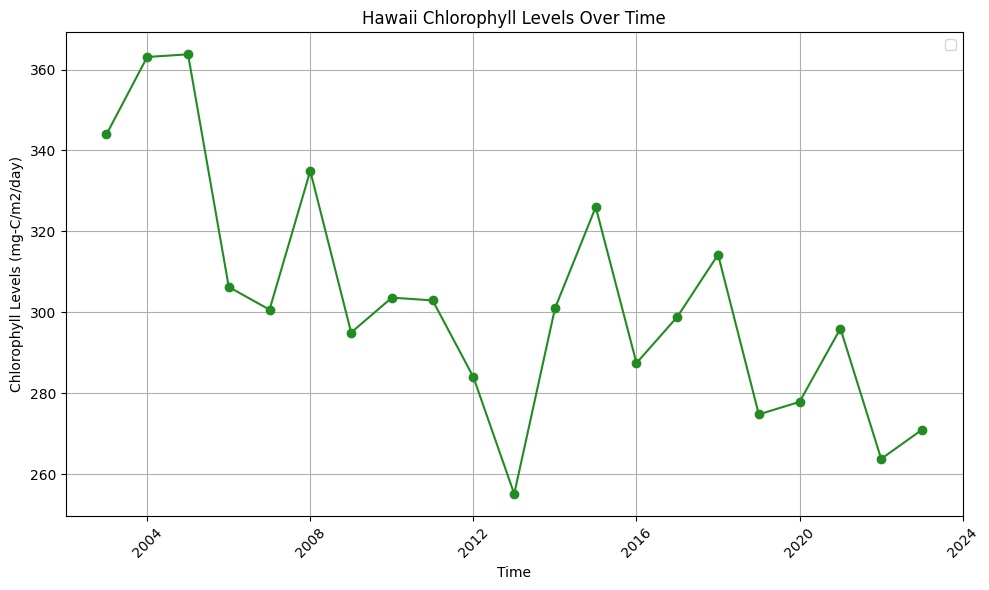

In [ ]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(plank_avg['time'], plank_avg['Chlorophyll Levels (mg-C/m2/day)'], marker='o', linestyle='-', color='forestgreen')
plt.title('Hawaii Chlorophyll Levels Over Time')
plt.xlabel('Time')
plt.ylabel('Chlorophyll Levels (mg-C/m2/day)')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()


### Correlation matrix

<ipython-input-23-6166489dc7ca>:8: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  ph_resampled = ph.resample('A').mean()
<ipython-input-23-6166489dc7ca>:9: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  co2_resampled = co2.resample('A').mean()
<ipython-input-23-6166489dc7ca>:10: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  temp_resampled = temp_avg.resample('A').mean()
<ipython-input-23-6166489dc7ca>:11: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  volcano_resampled = volcano.resample('A').mean()
<ipython-input-23-6166489dc7ca>:12: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  plank_resampled = plank_avg.resample('A').mean()
<ipython-input-23-6166489dc7ca>:13: FutureWarning: 'A' is deprecated and will be removed in 

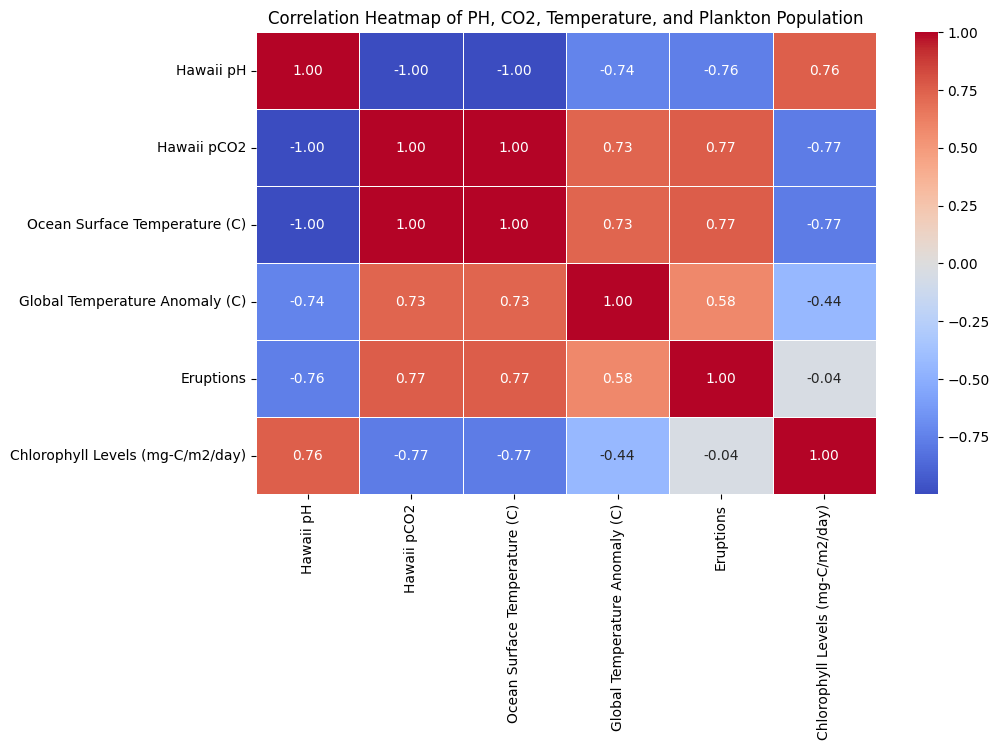

In [ ]:
ph.set_index('time', inplace=True)
co2.set_index('time', inplace=True)
temp_avg.set_index('time', inplace=True)
volcano.set_index('time', inplace=True)
plank_avg.set_index('time', inplace=True)
global_temp.set_index('time', inplace=True)

ph_resampled = ph.resample('A').mean()
co2_resampled = co2.resample('A').mean()
temp_resampled = temp_avg.resample('A').mean()
volcano_resampled = volcano.resample('A').mean()
plank_resampled = plank_avg.resample('A').mean()
global_temp_resampled = global_temp.resample('A').mean()

merged_df = pd.concat([ph_resampled, co2_resampled, temp_resampled, global_temp_resampled, volcano_resampled,plank_resampled], axis=1)

merged_df.interpolate(method='linear', inplace=True)

correlation_matrix = merged_df.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of PH, CO2, Temperature, and Plankton Population')
plt.show()

# ANALYSIS

###Prep data for ARIMAX

In [ ]:
from functools import reduce

dfs = [co2, temp_avg, global_temp, volcano,ph, plank_avg]

# Using reduce to merge all DataFrames on 'id'
df = reduce(lambda left, right: pd.merge(left, right, on='time', how='outer'), dfs)
df.dropna(axis=0, inplace=True)
df.head()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Make Stationary

In [ ]:
# Drop NAs
df = df.dropna(subset=['Hawaii pCO2', 'Ocean Surface Temperature (C)', 'Global Temperature Anomaly (C)', 'Eruptions'])  # Drop rows with NaN values in any relevant column

def check_stationarity(series):
    adf_result = adfuller(series)
    print(f"ADF Statistic: {adf_result[0]}")
    print(f"p-value: {adf_result[1]}")
    return adf_result[1] < 0.05  # If p-value < 0.05, the series is stationary

# Differencing and checking NaNs after
for col in ['Hawaii pCO2', 'Ocean Surface Temperature (C)', 'Global Temperature Anomaly (C)', 'Eruptions']:
    print(f"\nChecking stationarity for {col}...")
    is_stationary = check_stationarity(df[col])
    if not is_stationary:
        print(f"{col} is non-stationary. Differencing will be applied.")
        df[col] = df[col].diff()  # Apply differencing

        df[col] = df[col].dropna()  # Drop NaN values after differencing

    print(f"Checking for NaN values in {col} after differencing: {df[col].isna().sum()} NaN values")

    if df[col].isna().sum() > 0:
        print(f"Warning: {col} still has NaN values after differencing and dropna.")



Checking stationarity for Hawaii pCO2...
ADF Statistic: 1.7228978947275553
p-value: 0.9981831852764903
Hawaii pCO2 is non-stationary. Differencing will be applied.
Checking for NaN values in Hawaii pCO2 after differencing: 1 NaN values

Checking stationarity for Ocean Surface Temperature (C)...
ADF Statistic: 1.7228978947275553
p-value: 0.9981831852764903
Ocean Surface Temperature (C) is non-stationary. Differencing will be applied.
Checking for NaN values in Ocean Surface Temperature (C) after differencing: 1 NaN values

Checking stationarity for Global Temperature Anomaly (C)...
ADF Statistic: -1.5245347412632217
p-value: 0.5213413337063606
Global Temperature Anomaly (C) is non-stationary. Differencing will be applied.
Checking for NaN values in Global Temperature Anomaly (C) after differencing: 1 NaN values

Checking stationarity for Eruptions...
ADF Statistic: -4.428232027320819
p-value: 0.0002644835215098699
Checking for NaN values in Eruptions after differencing: 0 NaN values


In [ ]:
df.dropna(axis=0, inplace=True)
df

,time,Hawaii pCO2,Ocean Surface Temperature (C),Global Temperature Anomaly (C),Eruptions,Hawaii pH,Chlorophyll Levels (mg-C/m2/day)
16,2004-01-01,1.106818,1.106818,0.08,81.0,8.090558,363.109500
17,2005-01-01,9.105000,9.105000,-0.07,83.0,8.082600,363.770167
18,2006-01-01,-4.013333,-4.013333,0.13,86.0,8.086792,306.247333
19,2007-01-01,10.027778,10.027778,-0.06,81.0,8.076756,300.640167
20,2008-01-01,-1.694444,-1.694444,-0.37,86.0,8.079025,334.938917
21,2009-01-01,5.910000,5.910000,0.21,75.0,8.075540,294.980083
22,2010-01-01,-2.737778,-2.737778,0.29,77.0,8.077878,303.611083
23,2011-01-01,-1.782222,-1.782222,-0.32,76.0,8.078360,302.930333
24,2012-01-01,11.850000,11.850000,0.01,81.0,8.067820,283.982583
25,2013-01-01,-0.430000,-0.430000,0.08,80.0,8.068870,255.085083


### Forecast pH

In [ ]:
pmdarima.auto_arima(df['Hawaii pH'], seasonal=False, m=12, trace=True, suppress_warnings=True)

/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/pyt

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-131.434, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-130.875, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-134.925, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-136.744, Time=0.06 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-129.243, Time=0.09 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-135.479, Time=0.91 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-132.313, Time=0.97 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-133.486, Time=0.79 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-128.369, Time=0.31 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 3.449 seconds


ARIMA(order=(0, 1, 1), scoring_args={}, suppress_warnings=True)

In [ ]:
df.set_index("time", inplace=True)
# Define target and exogenous variables
y = df["Hawaii pH"]
exog_vars = ["Hawaii pCO2", "Ocean Surface Temperature (C)", "Global Temperature Anomaly (C)", "Eruptions"]
X = df[exog_vars]

# Standardize the exogenous variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled_df = pd.DataFrame(X_scaled, columns=exog_vars, index=X.index)

# Fit ARIMAX model
model = SARIMAX(y, exog=X_scaled_df, order=(0,1,1), seasonal_order=(0,0,0,0), enforce_stationarity=False, enforce_invertibility=False)
results = model.fit()
print(results.summary())


                               SARIMAX Results                                
Dep. Variable:              Hawaii pH   No. Observations:                   19
Model:               SARIMAX(0, 1, 1)   Log Likelihood                  71.016
Date:                Sun, 23 Mar 2025   AIC                           -130.032
Time:                        22:30:00   BIC                           -125.397
Sample:                    01-01-2004   HQIC                          -129.795
                         - 01-01-2022                                         
Covariance Type:                  opg                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Hawaii pCO2                       -0.0014      0.000     -5.743      0.000      -0.002      -0.001
Ocean Surface Temperature (C)     -0.0014      0.000     -5.743      0.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


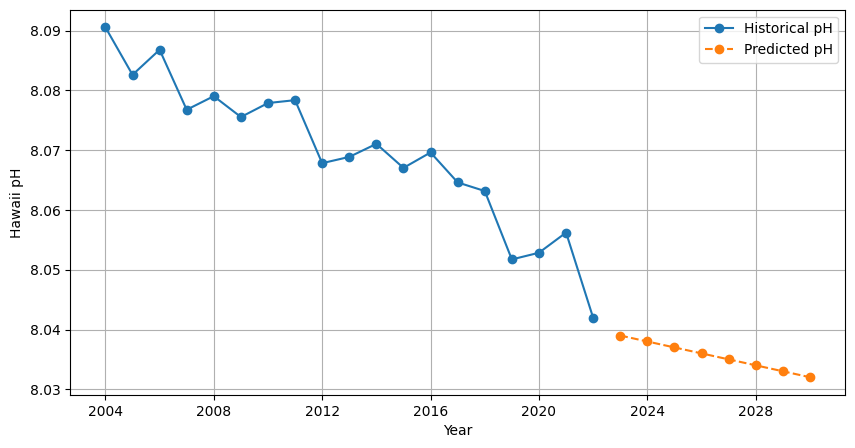

In [ ]:
# Create future date range (2023-2030)
future_dates = pd.date_range(start="2023-01-01", end="2030-01-01", freq="YS")

# Assuming constant growth or trends for predictors (modify based on knowledge)
future_exog = pd.DataFrame({
    "Hawaii pCO2": np.linspace(df["Hawaii pCO2"].iloc[-1], df["Hawaii pCO2"].iloc[-1] + 20, len(future_dates)),
    "Ocean Surface Temperature (C)": np.linspace(df["Ocean Surface Temperature (C)"].iloc[-1], df["Ocean Surface Temperature (C)"].iloc[-1] + 1, len(future_dates)),
    "Global Temperature Anomaly (C)": np.linspace(df["Global Temperature Anomaly (C)"].iloc[-1], df["Global Temperature Anomaly (C)"].iloc[-1] + 0.5, len(future_dates)),
    "Eruptions": [0] * len(future_dates)  # Assuming no major eruptions
}, index=future_dates)

# Scale future exogenous variables
future_exog_scaled = scaler.transform(future_exog)

# Convert back to DataFrame
future_exog_scaled_df = pd.DataFrame(future_exog_scaled, columns=exog_vars, index=future_dates)

# Predict future pH values
forecast = results.forecast(steps=len(future_dates), exog=future_exog_scaled_df)

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(df.index, df["Hawaii pH"], label="Historical pH", marker="o")
plt.plot(future_dates, forecast, label="Predicted pH", marker="o", linestyle="dashed")
plt.xlabel("Year")
plt.ylabel("Hawaii pH")
plt.legend()
plt.grid()
plt.show()


### Forecast pH: statistical testing

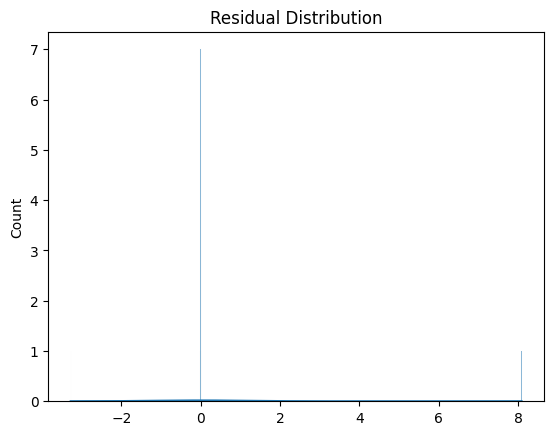

Shapiro-Wilk Test: Statistic=0.39925639232119103, p-value=7.219432236644757e-08
Residuals deviate from normality.


In [ ]:
import seaborn as sns
from scipy.stats import shapiro

# Get residuals
residuals = results.resid

# Plot histogram
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.show()

# Shapiro-Wilk Test for normality
shapiro_test = shapiro(residuals)
print(f"Shapiro-Wilk Test: Statistic={shapiro_test.statistic}, p-value={shapiro_test.pvalue}")

# Interpretation
if shapiro_test.pvalue > 0.05:
    print("Residuals appear to be normally distributed.")
else:
    print("Residuals deviate from normality.")



In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Perform Ljung-Box test
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(lb_test)

# Interpretation
if lb_test["lb_pvalue"].values[0] > 0.05:
    print("Residuals are uncorrelated (Good).")
else:
    print("Residuals exhibit autocorrelation (Consider revising model).")


     lb_stat  lb_pvalue
10  2.622528   0.988967
Residuals are uncorrelated (Good).


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Get in-sample predictions
y_pred = results.fittedvalues

# Calculate error metrics
mae = mean_absolute_error(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


Mean Absolute Error (MAE): 0.6001
Mean Squared Error (MSE): 4.0088
Root Mean Squared Error (RMSE): 2.0022
R² Score: -26751.7749


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


Test MAE: 0.0093
Test RMSE: 0.0096
Test R²: -2.2705


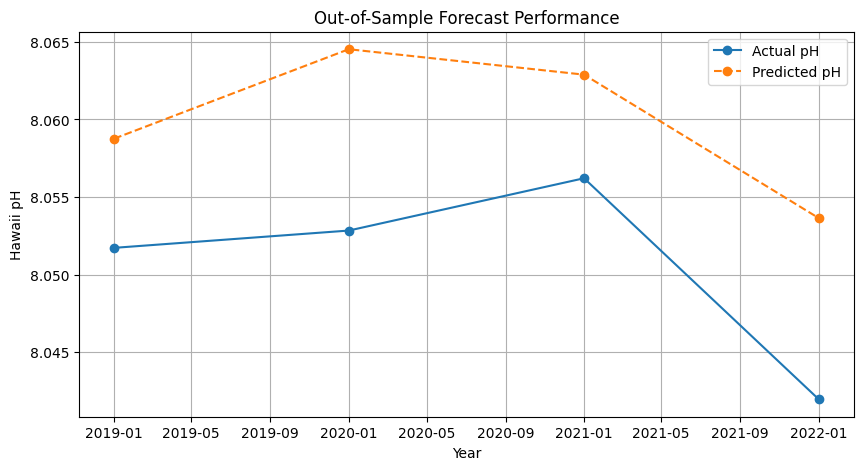

In [ ]:
# Split data (80% train, 20% test)
split_idx = int(len(y) * 0.8)
train_y, test_y = y.iloc[:split_idx], y.iloc[split_idx:]
train_X, test_X = X_scaled_df.iloc[:split_idx], X_scaled_df.iloc[split_idx:]

# Fit model on training data
model_train = SARIMAX(train_y, exog=train_X, order=(1,1,1), seasonal_order=(0,0,0,0))
results_train = model_train.fit()

# Forecast on test data
test_pred = results_train.forecast(steps=len(test_y), exog=test_X)

# Compute accuracy on test set
mae_test = mean_absolute_error(test_y, test_pred)
rmse_test = np.sqrt(mean_squared_error(test_y, test_pred))
r2_test = r2_score(test_y, test_pred)

print(f"Test MAE: {mae_test:.4f}")
print(f"Test RMSE: {rmse_test:.4f}")
print(f"Test R²: {r2_test:.4f}")

# Plot actual vs. predicted
plt.figure(figsize=(10, 5))
plt.plot(test_y.index, test_y, label="Actual pH", marker="o")
plt.plot(test_y.index, test_pred, label="Predicted pH", marker="o", linestyle="dashed")
plt.xlabel("Year")
plt.ylabel("Hawaii pH")
plt.legend()
plt.grid()
plt.title("Out-of-Sample Forecast Performance")
plt.show()

#If test RMSE >> train RMSE, the model overfits.


### Forecast Plankton

In [ ]:
# Define target variable (Plankton Population Proxy)
y_plankton = df["Chlorophyll Levels (mg-C/m2/day)"]

# Define predictor (pH)
X_pH = df[["Hawaii pH"]]

# Train-Test Split (Optional for validation)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_pH, y_plankton, test_size=0.2, random_state=42)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Fit linear model
model_plankton = LinearRegression()
model_plankton.fit(X_train, y_train)

# Predictions on test set
y_pred_test = model_plankton.predict(X_test)

# Evaluate model performance
mae = mean_absolute_error(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}")


MAE: 35.1534, RMSE: 39.5570


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


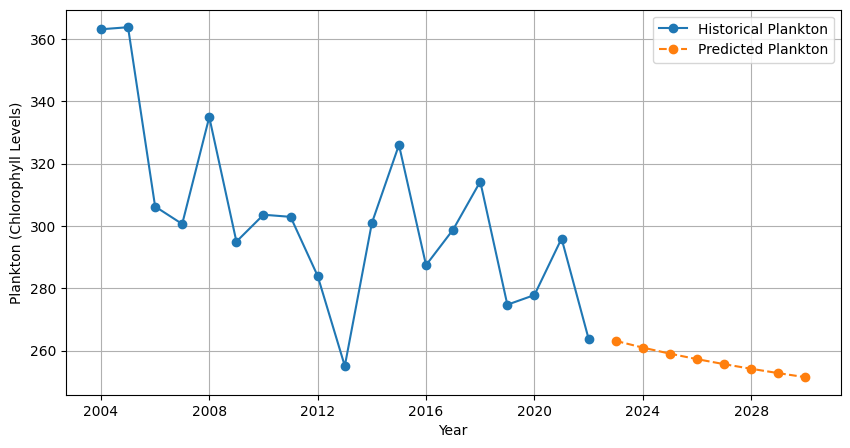

In [ ]:
# Predict plankton populations using future pH predictions
future_plankton = model_plankton.predict(forecast.values.reshape(-1, 1))

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(df.index, df["Chlorophyll Levels (mg-C/m2/day)"], label="Historical Plankton", marker="o")
plt.plot(future_dates, future_plankton, label="Predicted Plankton", marker="o", linestyle="dashed")
plt.xlabel("Year")
plt.ylabel("Plankton (Chlorophyll Levels)")
plt.legend()
plt.grid()
plt.show()


###Forecast Plankton: Statistical Tests

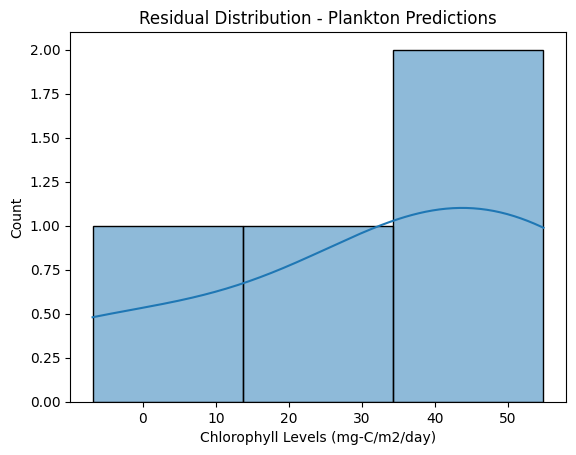

Shapiro-Wilk Test: Statistic=0.8926604626153445, p-value=0.3955246343131717
Residuals appear to be normally distributed (Good).


In [ ]:
import seaborn as sns
from scipy.stats import shapiro

# Get residuals (errors)
residuals_plankton = y_test - y_pred_test

# Plot histogram of residuals
sns.histplot(residuals_plankton, kde=True)
plt.title("Residual Distribution - Plankton Predictions")
plt.show()

# Shapiro-Wilk Test for normality
shapiro_test = shapiro(residuals_plankton)
print(f"Shapiro-Wilk Test: Statistic={shapiro_test.statistic}, p-value={shapiro_test.pvalue}")

# Interpretation
if shapiro_test.pvalue > 0.05:
    print("Residuals appear to be normally distributed (Good).")
else:
    print("Residuals deviate from normality (Consider transforming data).")


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Compute error metrics
mae_plankton = mean_absolute_error(y_test, y_pred_test)
mse_plankton = mean_squared_error(y_test, y_pred_test)
rmse_plankton = np.sqrt(mse_plankton)
r2_plankton = r2_score(y_test, y_pred_test)

print(f"Mean Absolute Error (MAE): {mae_plankton:.4f}")
print(f"Mean Squared Error (MSE): {mse_plankton:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_plankton:.4f}")
print(f"R² Score: {r2_plankton:.4f}")


Mean Absolute Error (MAE): 35.1534
Mean Squared Error (MSE): 1564.7550
Root Mean Squared Error (RMSE): 39.5570
R² Score: -0.9055


In [ ]:
# Predict on train set
y_train_pred = model_plankton.predict(X_train)

# Compute accuracy on train set
mae_train = mean_absolute_error(y_train, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))

print(f"Train MAE: {mae_train:.4f}, Train RMSE: {rmse_train:.4f}")
print(f"Test MAE: {mae_plankton:.4f}, Test RMSE: {rmse_plankton:.4f}")

# Compare train vs. test errors
if rmse_plankton > rmse_train * 1.2:
    print("Model may be overfitting. Consider regularization or adding more data.")


Train MAE: 10.5874, Train RMSE: 15.5332
Test MAE: 35.1534, Test RMSE: 39.5570
Model may be overfitting. Consider regularization or adding more data.


In [ ]:
import statsmodels.api as sm

# Fit OLS model to compute AIC/BIC
X_train_with_const = sm.add_constant(X_train)
ols_model = sm.OLS(y_train, X_train_with_const).fit()

print(f"AIC: {ols_model.aic}")
print(f"BIC: {ols_model.bic}")


AIC: 128.85756658617487
BIC: 130.2736669883793
